# Evaluation of Aligned Paragraphs with Semantic Similarity Metrics

We need to evaluate the quality of the par3 paragraph alignments.

We chose a few similarity metrics to try out and compare:
- BLEU: [BLEU: a Method for Automatic Evaluation of Machine Translation](https://aclanthology.org/P02-1040.pdf)
- BERTScore: [BERTScore: Evaluating Text Generation with BERT](https://arxiv.org/pdf/1904.09675)
- BLEURT: [BLEURT: Learning Robust Metrics for Text Generation](https://arxiv.org/pdf/2004.04696)
- SIM score [Beyond BLEU: Training Neural Machine Translation with Semantic Similarity](https://arxiv.org/pdf/1909.06694)

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"

In [2]:
import torch

if torch.cuda.is_available():
  dev = "cuda"
else:
  dev = "cpu"
device = torch.device(dev)

print(device)

cuda


## Implementing the similarity metrics

Let's try out the similarity metrics on a cherry-picked example from our dataset. We choose an aligned paragraph and get the source text (reference) and the translations (hypotheses).

In [4]:
import pickle
with open('/home/kkatsy/ru_alignment_dataset/NotesFromUnderground_ru/aligned.pkl', 'rb') as fp:
  poorfolk_dict = pickle.load(fp)

In [5]:
poorfolk_dict['translator_data'].keys()

dict_keys(['ru_alignment_dataset/NotesFromUnderground_ru/trans_txts/NotesFromUnderground_Garnett.txt', 'ru_alignment_dataset/NotesFromUnderground_ru/trans_txts/NotesFromUnderground_PV.txt', 'ru_alignment_dataset/NotesFromUnderground_ru/trans_txts/NotesFromUnderground_Katz.txt', 'NotesFromUnderground_Garnett', 'NotesFromUnderground_PV', 'NotesFromUnderground_Katz'])

In [6]:
human_translations = []
for t in poorfolk_dict['translator_data'].keys():
  if 'txt' not in t:
    h = poorfolk_dict['translator_data'][t]['translator_paras'][260]
    human_translations.append(h)
    print(h)

"You are a scoundrel," a thought flashed through my mind, "if you laugh at this now."
"What a scoundrel you are," raced through my head, "to laugh at that now!"
"You're a scoundrel," the thought flashed through my mind, "if you laugh at that now.'


In [7]:
poorfolk_dict['source_paras'][260]

'«Подлец ты!— пронеслось в моей голове,— коли над этим теперь смеешься».'

In [8]:
poorfolk_dict['gt_paras'][260]

'“You are a scoundrel!” Flawed in my head, “if you are laughing now.”'

In [9]:
references = human_translations
hypothesis = poorfolk_dict['gt_paras'][260]

### BLEU

Library: [https://github.com/mjpost/sacrebleu](https://github.com/mjpost/sacrebleu)

In [10]:
from sacrebleu.metrics import BLEU, CHRF, TER

refs = [ ['The dog bit the man.', 'It was not unexpected.', 'The man bit him first.']]
sys = ['The dog bit the man.', "It wasn't surprising.", 'The man had just bitten him.']

refs = [[r] for r in references[1:]]
sys = [references[0]]
print(refs)
print(sys)

bleu = BLEU()
bleu.corpus_score(sys, refs)

[['"What a scoundrel you are," raced through my head, "to laugh at that now!"'], ['"You\'re a scoundrel," the thought flashed through my mind, "if you laugh at that now.\'']]
['"You are a scoundrel," a thought flashed through my mind, "if you laugh at this now."']


BLEU = 60.10 87.0/63.6/52.4/45.0 (BP = 1.000 ratio = 1.045 hyp_len = 23 ref_len = 22)

In [11]:
for r in references[1:]:
    sys = [references[0]]
    refs = [[r]]
    print(bleu.corpus_score(sys, refs))
    print(sys)
    print(refs)

BLEU = 8.15 65.2/22.7/2.4/1.2 (BP = 1.000 ratio = 1.095 hyp_len = 23 ref_len = 21)
['"You are a scoundrel," a thought flashed through my mind, "if you laugh at this now."']
[['"What a scoundrel you are," raced through my head, "to laugh at that now!"']]
BLEU = 58.53 78.3/63.6/52.4/45.0 (BP = 1.000 ratio = 1.045 hyp_len = 23 ref_len = 22)
['"You are a scoundrel," a thought flashed through my mind, "if you laugh at this now."']
[['"You\'re a scoundrel," the thought flashed through my mind, "if you laugh at that now.\'']]


In [12]:
human_translations

['"You are a scoundrel," a thought flashed through my mind, "if you laugh at this now."',
 '"What a scoundrel you are," raced through my head, "to laugh at that now!"',
 '"You\'re a scoundrel," the thought flashed through my mind, "if you laugh at that now.\'']

### BERT Score

Library: [https://github.com/Tiiiger/bert_score](https://github.com/Tiiiger/bert_score) 

In [13]:
from bert_score import score as bertscore

cands = [human_translations[0], human_translations[0]]
refs = [human_translations[1], human_translations[2]]
P, R, F1 = bertscore(cands, refs, lang="en", verbose=True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.28 seconds, 7.13 sentences/sec


In [14]:
F1 = [tensor.item() for tensor in F1]
F1

[0.9508187770843506, 0.9804180860519409]

In [14]:
from bert_score import plot_example

# plot_example(cands[0], refs[0], lang="en")

### BLEURT

Library: [https://github.com/lucadiliello/bleurt-pytorch](https://github.com/lucadiliello/bleurt-pytorch)

In [15]:
import torch
from bleurt_pytorch import BleurtConfig, BleurtForSequenceClassification, BleurtTokenizer

config = BleurtConfig.from_pretrained('lucadiliello/bleurt-large-512')
bleurt_model = BleurtForSequenceClassification.from_pretrained('lucadiliello/bleurt-large-512')
bleurt_tokenizer = BleurtTokenizer.from_pretrained('lucadiliello/bleurt-large-512')

references = ["this is a random sentence", "this is a random sentence"]
candidates = ["this looks like a random sentence", "this is a another out-there sentence"]

bleurt_model.eval()
with torch.no_grad():
    inputs = bleurt_tokenizer(references, candidates, padding='longest', return_tensors='pt')
    print(inputs)
    res = bleurt_model(**inputs).logits.flatten().tolist()
print(res)

/home/kkatsy/anaconda3/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


{'input_ids': tensor([[ 101, 2023, 2003, 1037, 6721, 6251,  102, 2023, 3504, 2066, 1037, 6721,
         6251,  102,    0,    0],
        [ 101, 2023, 2003, 1037, 6721, 6251,  102, 2023, 2003, 1037, 2178, 2041,
         1011, 2045, 6251,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
[0.8036925196647644, -0.7710185647010803]


### SIM Score

To use the SIM score metric, load in the sim models files from the par3 directory you cloned: \
`%load par3/par3_align/similarity/sim_models.py`\
`%load par3/par3_align/similarity/sim_utils.py`\
`%load par3/par3_align/similarity/test_sim.py`

In [16]:
# %load par3/par3_align/similarity/sim_models.py

import torch
import torch.nn as nn
from torch.nn.modules.distance import CosineSimilarity
import numpy as np

class ParaModel(nn.Module):

    def __init__(self, args, vocab):
        super(ParaModel, self).__init__()

        self.args = args
        self.vocab = vocab
        self.gpu = args.gpu

        self.cosine = CosineSimilarity()

    def compute_mask(self, lengths):

        lengths = lengths.cpu()
        max_len = torch.max(lengths)
        range_row = torch.arange(0, max_len).long()[None, :].expand(lengths.size()[0], max_len)
        mask = lengths[:, None].expand_as(range_row)
        mask = range_row < mask
        mask = mask.float()
        if self.gpu >= 0:
            mask = mask.cuda()
        return mask

    def torchify_batch(self, batch):

        max_len = 0
        for i in batch:
            if len(i.embeddings) > max_len:
                max_len = len(i.embeddings)

        batch_len = len(batch)

        np_sents = np.zeros((batch_len, max_len), dtype='int32')
        np_lens = np.zeros((batch_len,), dtype='int32')

        for i, ex in enumerate(batch):
            np_sents[i, :len(ex.embeddings)] = ex.embeddings
            np_lens[i] = len(ex.embeddings)

        idxs, lengths, masks = torch.from_numpy(np_sents).long(), \
                               torch.from_numpy(np_lens).float().long(), \
                               self.compute_mask(torch.from_numpy(np_lens).long())

        if self.gpu >= 0:
            idxs = idxs.cuda()
            lengths = lengths.cuda()
            masks = masks.cuda()
    
        return idxs, lengths, masks

    def scoring_function(self, g_idxs1, g_mask1, g_lengths1, g_idxs2, g_mask2, g_lengths2):

        g1 = self.encode(g_idxs1, g_mask1, g_lengths1)
        g2 = self.encode(g_idxs2, g_mask2, g_lengths2)
        return self.cosine(g1, g2)

class WordAveraging(ParaModel):

    def __init__(self, args, vocab):
        super(WordAveraging, self).__init__(args, vocab)

        self.vocab = vocab
        self.embedding = nn.Embedding(len(self.vocab), self.args.dim)

        if args.gpu >= 0:
           self.cuda()

    def encode(self, idxs, mask, lengths):
        word_embs = self.embedding(idxs)
        word_embs = word_embs * mask[:, :, None]
        g = word_embs.sum(dim=1) / lengths[:, None].float()
        return g

In [17]:
# %load par3/par3_align/similarity/sim_utils.py

import io
import numpy as np
import torch

def get_wordmap(textfile):
    words={}
    We = []
    f = io.open(textfile, 'r', encoding='utf-8')
    lines = f.readlines()
    if len(lines[0].split()) == 2:
        lines.pop(0)
    ct = 0
    for (n,i) in enumerate(lines):
        word = i.split(' ', 1)[0]
        vec = i.split(' ', 1)[1].split(' ')
        j = 0
        v = []
        while j < len(vec):
            v.append(float(vec[j]))
            j += 1
        words[word] = ct
        ct += 1
        We.append(v)
    return words, np.array(We)

def get_minibatches_idx(n, minibatch_size, shuffle=False):
    idx_list = np.arange(n, dtype="int32")

    if shuffle:
        np.random.shuffle(idx_list)

    minibatches = []
    minibatch_start = 0
    for i in range(n // minibatch_size):
        minibatches.append(idx_list[minibatch_start:
                                    minibatch_start + minibatch_size])
        minibatch_start += minibatch_size

    if (minibatch_start != n):
        # Make a minibatch out of what is left
        minibatches.append(idx_list[minibatch_start:])

    return zip(range(len(minibatches)), minibatches)

def max_pool(x, lengths, gpu):
    out = torch.FloatTensor(x.size(0), x.size(2)).zero_()
    if gpu >= 0:
        out = out.cuda()
    for i in range(len(lengths)):
        out[i] = torch.max(x[i][0:lengths[i]], 0)[0]
    return out

def mean_pool(x, lengths, gpu):
    out = torch.FloatTensor(x.size(0), x.size(2)).zero_()
    if gpu >= 0:
        out = out.cuda()
    for i in range(len(lengths)):
        out[i] = torch.mean(x[i][0:lengths[i]], 0)
    return out

def lookup(words, w):
    w = w.lower()
    if w in words:
        return words[w]

class Example(object):

    def __init__(self, sentence):
        self.sentence = sentence.strip().lower()
        self.embeddings = []
        self.representation = None

    def populate_embeddings(self, words):
        sentence = self.sentence.lower()
        arr = sentence.split()
        for i in arr:
            emb = lookup(words, i)
            if emb:
                self.embeddings.append(emb)
        if len(self.embeddings) == 0:
            self.embeddings.append(words['UUUNKKK'])

In [ ]:
# %load par3/par3_align/similarity/test_sim.py
import torch

# from par3_align.similarity.sim_models import WordAveraging
# from par3_align.similarity.sim_utils import Example
from nltk.tokenize import TreebankWordTokenizer
import sentencepiece as spm

tok = TreebankWordTokenizer()

model = torch.load('par3/par3_align/similarity/sim/sim.pt')
state_dict = model['state_dict']
vocab_words = model['vocab_words']
args = model['args']
# turn off gpu
model = WordAveraging(args, vocab_words)
model.load_state_dict(state_dict, strict=True)
sp = spm.SentencePieceProcessor()
sp.Load('par3/par3_align/similarity/sim/sim.sp.30k.model')
model.eval()

def make_example(sentence, model):
    sentence = sentence.lower()
    sentence = " ".join(tok.tokenize(sentence))
    sentence = sp.EncodeAsPieces(sentence)
    wp1 = Example(" ".join(sentence))
    wp1.populate_embeddings(model.vocab)
    return wp1

def find_similarity(s1, s2):
    with torch.no_grad():
        s1 = [make_example(x, model) for x in s1]
        s2 = [make_example(x, model) for x in s2]
        wx1, wl1, wm1 = model.torchify_batch(s1)
        wx2, wl2, wm2 = model.torchify_batch(s2)
        BATCH_SIZE = 512
        all_scores = []
        for i in range(0, len(wx1), BATCH_SIZE):
            scores = model.scoring_function(wx1[i:i + BATCH_SIZE], wm1[i:i + BATCH_SIZE], wl1[i:i + BATCH_SIZE],
                                            wx2[i:i + BATCH_SIZE], wm2[i:i + BATCH_SIZE], wl2[i:i + BATCH_SIZE])
            all_scores.extend([x.item() for x in scores])
        return all_scores

def find_similarity_matrix(s1, s2):
    with torch.no_grad():
        s1 = [make_example(x, model) for x in s1]
        s2 = [make_example(x, model) for x in s2]
        wx1, wl1, wm1 = model.torchify_batch(s1)
        wx2, wl2, wm2 = model.torchify_batch(s2)

        BATCH_SIZE = 2000
        vecs1 = []
        vecs2 = []
        for i in range(0, len(wx1), BATCH_SIZE):
            curr_vecs1 = model.encode(idxs=wx1[i:i + BATCH_SIZE],
                                      mask=wm1[i:i + BATCH_SIZE],
                                      lengths=wl1[i:i + BATCH_SIZE])
            vecs1.append(curr_vecs1)
        for i in range(0, len(wx2), BATCH_SIZE):
            curr_vecs2 = model.encode(idxs=wx2[i:i + BATCH_SIZE],
                                      mask=wm2[i:i + BATCH_SIZE],
                                      lengths=wl2[i:i + BATCH_SIZE])
            vecs2.append(curr_vecs2)
        vecs1 = torch.cat(vecs1)
        vecs2 = torch.cat(vecs2)
        dot_product = torch.matmul(vecs1, vecs2.t())

        vecs1_norm = torch.norm(vecs1, dim=1, keepdim=True)
        vecs2_norm = torch.norm(vecs2, dim=1, keepdim=True)
        norm_product = torch.matmul(vecs1_norm, vecs2_norm.t())
    return torch.div(dot_product, norm_product)

def encode_text(s1):
    with torch.no_grad():
        s1 = [make_example(x, model) for x in s1]
        wx1, wl1, wm1 = model.torchify_batch(s1)
        vecs1 = model.encode(idxs=wx1, mask=wm1, lengths=wl1)
        return vecs1


In [19]:
tok = TreebankWordTokenizer()

model = torch.load('par3/par3_align/similarity/sim/sim.pt')
state_dict = model['state_dict']
vocab_words = model['vocab_words']
args = model['args']
# turn off gpu
model = WordAveraging(args, vocab_words)
model.load_state_dict(state_dict, strict=True)
sp = spm.SentencePieceProcessor()
sp.Load('par3/par3_align/similarity/sim/sim.sp.30k.model')
model.eval()

WordAveraging(
  (cosine): CosineSimilarity()
  (embedding): Embedding(65733, 300)
)

In [20]:
s1 = [human_translations[0], human_translations[2]]
s2 = [human_translations[1], human_translations[0]]

s1

['"You are a scoundrel," a thought flashed through my mind, "if you laugh at this now."',
 '"You\'re a scoundrel," the thought flashed through my mind, "if you laugh at that now.\'']

In [21]:
find_similarity(s1, s2)

[0.7659345865249634, 0.949976921081543]

In [22]:
# ideas: look at longer len alignments

## Sorting Paragraph Alignments by Similarity Metrics

Defining helper function to get similarity scores, sort aligned pars by their similarity scores, and filter out aligned pars based on best/worse similarity scores in order to explore and evaluate aligned dataset.

In [23]:
with open('aligned_paragraph_dataset.pickle', 'rb') as fp:
  aligned_paragraph_dataset = pickle.load(fp)

In [24]:
aligned_paragraph_dataset['NotesFromUnderground'][240]

{'Garnett': '"But let us pass. Why are you barring our way? What do you want?" Zverkov answered disdainfully. They were all flushed, their eyes were bright: they had been drinking heavily.',
 'PV': '"Let us pass, why\'re you standing in the way!...What do you want?" Zverkov responded contemptuously. Their faces were red; their eyes were shiny: they had drunk a lot.',
 'Katz': '"Allow us to pass; why are you blocking our way? . .. Well, what is it you want?" Zverkov asked contemptuously. They were all flushed, their eyes glazed. They\'d  drunk a great deal.'}

### Helper functions

In [25]:
"""
Get similarity scores of source + translated paragraphs in a uniform format.
"""
def get_score(refs, cands, metric):
    scores = -1
    if metric == 'bleu':
        scores = []
        for r,c, in zip(refs, cands):
            s =  (bleu.corpus_score([r], [[c]])).score
            scores.append(s)

    elif metric == 'bleurt':
        with torch.no_grad():
            inputs = bleurt_tokenizer(refs, cands, padding='max_length', truncation=True, return_tensors='pt')
            res = bleurt_model(**inputs).logits.flatten().tolist()
        scores = res

    elif metric == 'bert_score':
        P, R, F1 = bertscore(refs, cands, lang="en", verbose=True)
        scores = [tensor.item() for tensor in F1]
        
    elif metric == 'sim':
        scores = find_similarity(refs,cands)

    return scores

In [26]:
sents = list(aligned_paragraph_dataset['NotesFromUnderground'][260].values())
s1 = [sents[0]*19, sents[1], sents[2]]
s2 = [sents[1], sents[2]*18, sents[0]]
print(s1)
print(s2)
get_score(s1,s2, metric='bleurt')

['"You are a scoundrel," a thought flashed through my mind, "if you laugh at this now.""You are a scoundrel," a thought flashed through my mind, "if you laugh at this now.""You are a scoundrel," a thought flashed through my mind, "if you laugh at this now.""You are a scoundrel," a thought flashed through my mind, "if you laugh at this now.""You are a scoundrel," a thought flashed through my mind, "if you laugh at this now.""You are a scoundrel," a thought flashed through my mind, "if you laugh at this now.""You are a scoundrel," a thought flashed through my mind, "if you laugh at this now.""You are a scoundrel," a thought flashed through my mind, "if you laugh at this now.""You are a scoundrel," a thought flashed through my mind, "if you laugh at this now.""You are a scoundrel," a thought flashed through my mind, "if you laugh at this now.""You are a scoundrel," a thought flashed through my mind, "if you laugh at this now.""You are a scoundrel," a thought flashed through my mind, "if y

[-0.7500023245811462, 0.2100936621427536, 0.8938102722167969]

In [27]:
len(sents[0])

85

In [28]:
sorted_keys = sorted(list(aligned_paragraph_dataset.keys()))

In [29]:
# Create list of all valid aligned pars
# Don't care about which aligned pars belong to which book/translator right now
# Just want one giant list

aligned_par_list = []
par_index_list = []

for k in sorted(list(aligned_paragraph_dataset.keys())):
    for i in range(len(aligned_paragraph_dataset[k])):
        par_set = list(aligned_paragraph_dataset[k][i].values())
        #if all(p != '' for p in par_set):
        aligned_par_list.append(par_set)
        par_index_list.append(i)

aligned_par_list[10:15]

[['Worst of all had been that first moment when, coming back from the theatre, cheerful and content, holding a huge pear for his wife, he had not found her in the drawing room; to his surprise, he had not found her in the study either, and had finally seen her in the bedroom with the unfortunate, all-revealing note in her hand.',
  'Most unpleasant of all was the first minute when, on coming, happy and good-humored, from the theater, with a huge pear in his hand for his wife, he had not found his wife in the drawing-room, to his surprise had not found her in the study either, and saw her at last in her bedroom with the unlucky letter that revealed everything in her hand.'],
 ['She - this eternally preoccupied and bustling and, as he thought, none-too-bright Dolly - was sitting motionless, the note in her hand, looking at him with an expression of horror, despair and wrath.',
  'She, his Dolly, forever fussing and worrying over household details, and limited in her ideas, as he consider

#### Sorting + Filtering Aligned Paragraphs Based on Similarity Scores

We create a helper function to sort/filter out the aligned paragraphs. We sort based on a chosen similarity metric and we filter based on length and similarity score. With length, we filter out some of the paragraphs with near-perfect scores - perfect text matches don't give us any info about the translations; and we filter out the worst scores to discard low-quality paragraph alignments created by par3.

In [31]:
import itertools
from statistics import mean
from operator import itemgetter

"""
Sort + filter out aligned paragraphs based on a similarity metric.

Args:
        par_list: list of aligned par lists, [[par1_tr1, par1_tr2, par1_tr3], [par2_tr1, par2_tr2, par2_tr3], ...]
        top_k: num of aligned pars to return with highest similarity scores post-filtering for length
        drop_top: percent of aligned pars
        metric: 'bleu', 'bert_score', 'bleurt', or 'sim'
        min_len: drop aligned pars where pars are shorter than min length
        max_len: drop aligned pars where pars are longer than max length

    Returns:
        i2score: list of tuples, (aligned paragraph index, similarity score of paragraph translations) for all aligned paragraphs in list
        top_k_scores: list of tuples, (aligned paragraph index, similarity score of paragraph translations) for top k aligned paragraphs in list post-filtering
"""

def get_best_alignments(par_list, top_k, drop_top, metric, min_len, max_len):

    # dict -> score:par_set
    # iter thru par_list, prune by length, get metric for set
    keep_index_list = []
    i2score = {}
    for i in range(len(par_list)):
        keep_index_list.append(i)
        par_set = par_list[i]

        max_par_len = len(max(par_set, key = len))
        min_par_len = len(min(par_set, key = len))

        if (min_par_len >= min_len) and (max_par_len) <= max_len and not all(x==par_set[0] for x in par_set):

            pairs = list(itertools.combinations(par_set, 2))
            refs, cands = [], []
            for s1, s2 in pairs:
                refs.append(s1)
                cands.append(s2)
                
            pair_scores = get_score(refs, cands, metric)

            average_score = mean(pair_scores)
            i2score[i] = average_score

    # get top k par sets
    num_pars = len(list(i2score))
    top_k_scores = sorted(i2score.items(), key=itemgetter(1), reverse=True)[int(num_pars*drop_top):int(num_pars*drop_top) + top_k]
    return i2score, top_k_scores

### Evaluating Sim Alignments

In [37]:
min_paragraph_len = 100 
max_paragraph_len = 300
top_k = 20
drop_top = 0.1

In [38]:
i2score_sim, top_k_sim = get_best_alignments(aligned_par_list, top_k, drop_top, 'sim', min_paragraph_len, max_paragraph_len)
top_k_sim

[(31077, 0.9101430177688599),
 (3477, 0.9101111888885498),
 (7135, 0.9100863933563232),
 (26704, 0.9100073675314585),
 (30648, 0.9099908073743185),
 (29691, 0.9099846680959066),
 (29802, 0.909978191057841),
 (1154, 0.9099395275115967),
 (7572, 0.9099390506744385),
 (31418, 0.9099249045054117),
 (6116, 0.909909188747406),
 (6775, 0.9099080562591553),
 (26983, 0.9098943670590719),
 (2156, 0.9098352789878845),
 (1136, 0.909832239151001),
 (24876, 0.9097167650858561),
 (16992, 0.9096757173538208),
 (15335, 0.9096440076828003),
 (27392, 0.9096282720565796),
 (23212, 0.909601241350174)]

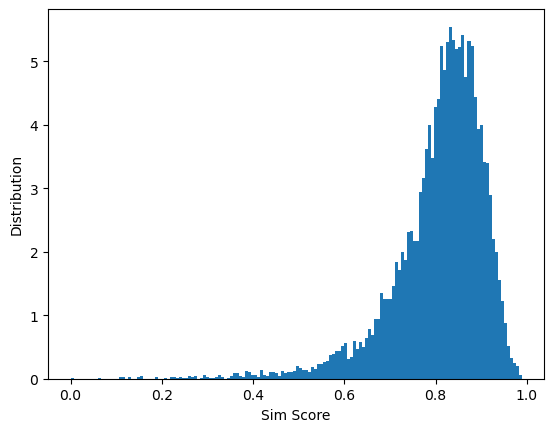

In [39]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(list(i2score_sim.values()), density=True, bins=150)  # density=False would make counts
plt.ylabel('Distribution')
plt.xlabel('Sim Score');

In [40]:
for i, s in top_k_sim:
    print(aligned_par_list[i])

['"If that\'s so, allow me to sit down," added Ippolit, seating himself with perfect composure in the chair where the general had been sitting. "After all 1 am ill, you know; well, now I\'m ready to listen to you, especially as this is our last conversation, perhaps indeed our last meeting."', "'If that's how it is, then allow me to sit down,' added Ippolit, very calmly sitting down on the chair the general had been seated on. 'I mean, I'm still sick, you see;  well, now I am ready to listen to you, all the more so as this is our last conversation and even, perhaps, our last meeting.'", '"But in that case, allow me to sit down," Ippolit added, sitting down most calmly on the chair that the general had been sitting on. "I am ill after all; well, now I\'m ready to listen to you, the more so as this is our last conversation and perhaps even our last meeting."']
['"You call it cruelty when a husband offers his wife freedom, giving her the honourable shelter of his name, only on condition t

In [41]:
import pandas as pd 

scores, pars = [], []
p1, p2, p3, p4 = [], [], [], []
for i, s in top_k_sim:
    par_set = aligned_par_list[i]
    if len(par_set) == 2:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append('')
        p4.append('')
    elif len(par_set) == 3:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append(par_set[2])
        p4.append('')
    elif len(par_set) == 4:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append(par_set[2])
        p4.append(par_set[3])

    pars.append(aligned_par_list[i])
    scores.append(s)
    
df = pd.DataFrame(list(zip(scores, p1, p2, p3, p4)), columns=['SIM score', 'translation 1', 'translation 2', 'translation 3', 'translation 4'])
pd.set_option('display.max_colwidth', 0)
df.head(top_k)

,SIM score,translation 1,translation 2,translation 3,translation 4
0,0.910143,"""If that's so, allow me to sit down,"" added Ippolit, seating himself with perfect composure in the chair where the general had been sitting. ""After all 1 am ill, you know; well, now I'm ready to listen to you, especially as this is our last conversation, perhaps indeed our last meeting.""","'If that's how it is, then allow me to sit down,' added Ippolit, very calmly sitting down on the chair the general had been seated on. 'I mean, I'm still sick, you see; well, now I am ready to listen to you, all the more so as this is our last conversation and even, perhaps, our last meeting.'","""But in that case, allow me to sit down,"" Ippolit added, sitting down most calmly on the chair that the general had been sitting on. ""I am ill after all; well, now I'm ready to listen to you, the more so as this is our last conversation and perhaps even our last meeting.""",
1,0.910111,"""You call it cruelty when a husband offers his wife freedom, giving her the honourable shelter of his name, only on condition that propriety is observed. Is that cruelty?""","""You call it cruelty for a husband to give his wife liberty, giving her the honorable protection of his name, simply on the condition of observing the proprieties: is that cruelty?""",,
2,0.910086,"'Yes, and I repeat that a man who reproaches me by saying he has sacrificed everything for me,' she said, recalling the words of a previous quarrel, 'is still worse than a dishonest man - he's aman with no heart!""","""Yes, and I repeat that the man who reproaches me with having sacrificed everything for me,"" she said, recalling the words of a still earlier quarrel, ""that he's worse than a dishonorable man—he's a heartless man.""",,
3,0.910007,"'No, I did not. I thought it was Dmitry. Brother! Brother! Ah!' He suddenly gripped his head with both hands. 'Listen: did you kill him on your own? With my brother, or without him?'","""No, I didn't know. I thought it was Dmitry. Brother! Brother! Ah!"" All of a sudden he grabbed hold of his head with both hands. ""Listen: did you kill him alone? Without my brother or with him?""","""No, I did not know. I kept thinking of Dmitri. Brother, brother! Ach!"" He suddenly clutched his head in both hands. ""Listen. Did you kill him alone? With my brother's help or without?""","""No, I didn't. I kept thinking it was Dmitri. Brother! Brother! Ah!"" he suddenly seized his head with both hands. ""Listen: did you kill him alone? Without my brother, or with him?"""
4,0.909991,"""IT want to run away from home—I want to,"" she cried, and again her eyes flashed. ""If you won't consent, I shall marry Gavril Ardalionovitch. I don't want to be looked upon as a horrid girl at home, and be accused of goodness knows what.""","'I want to run away from home, I want to!' she exclaimed, and again her eyes began to flash. 'If you won't agree, I'll marry Gavrila Ardalionovich. I don't want to be considered a fallen woman at home and accused of God knows what.","""I want it, I want to run away from home!"" she cried, and again her eyes flashed. ""If you don't agree, then I'll marry Gavrila Ardalionovich. I don't want to be considered a loathsome woman at home and be accused of God knows what.""",
5,0.909985,"""He is ashamed of his tears,"" Lebedyev whispered to Lizaveta Prokofyevna. ""That was bound to happen. Bravo, the prince! he saw right through him.""","'He's ashamed of his tears!' whispered Lebedev to Lizaveta Prokofyevna, ""This was bound to happen!"" Hurrah for the prince! Saw right through him...'","""Ashamed of his tears!"" Lebedev whispered to Lizaveta Prokofyevna. "" 'It had to be so!' That's the prince for you! Read right through him ...""",
6,0.909978,"""But I give up the word skeptic myself, I've found another explanation,"" Kolya cried suddenly. ""You're not a skeptic, but you're jealous! You're fiendishly jealous of Ganya over a certain proud young lady!""","'But I'll renounce the wor

### Evaluating BLEU Alignments

In [39]:
i2score_bleu, top_k_bleu = get_best_alignments(aligned_par_list, top_k, drop_top, 'bleu', min_paragraph_len, max_paragraph_len)
top_k_bleu

[(10980, 39.43060000156111),
 (1955, 39.429300582360725),
 (27558, 39.41885502952403),
 (4706, 39.41622338155528),
 (24345, 39.408855348303035),
 (3932, 39.407876466305666),
 (28044, 39.399494329902396),
 (3013, 39.39835969086693),
 (18316, 39.39012854872952),
 (29802, 39.38480984091733),
 (11161, 39.37366452559298),
 (1076, 39.36621655545065),
 (261, 39.34831043015918),
 (15090, 39.32176304492166),
 (17604, 39.31033599558367),
 (28335, 39.30880334505524),
 (5732, 39.3048537081746),
 (26437, 39.28487626698846),
 (29589, 39.271099680329876),
 (6518, 39.26640106292019)]

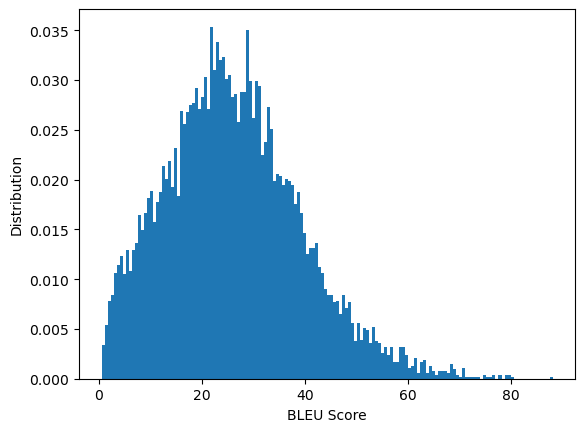

In [40]:
plt.hist(list(i2score_bleu.values()), density=True, bins=150)  # density=False would make counts
plt.ylabel('Distribution')
plt.xlabel('BLEU Score');

In [346]:
for i, s in top_k_bleu:
    print(aligned_par_list[i])

['"We\'ve sucked you dry, Sonya. ... Polya, Lyonya, Kolya, come here. ... Well, here they are, Sonya, all of them. Take them . . . from my hands into yours... . I\'ve had  enough! The party\'s over!" Cough! "Lay me back down. Let me die in peace..."', '"We have been your ruin, Sonia. Polenka, Lida, Kolya, come here! Well, here they are, Sonia, take them all! I hand them over to you, I\'ve had enough! The ball is over." (Cough!) "Lay me down, let me die in peace."', '"We\'ve sucked you dry, Sonya ... Polya, Lyonya, Kolya, come here ... Well, here they are, Sonya, all of them, take them ... from one set of hands to another ... but I\'ve had enough! The ball is over! Gh-ha! ... Lay me down again, let me at least die peacefully.\'', '"We\'ve sucked you dry, Sonya...Polya, Lenya, Kolya, come here... Well, Sonya, here they all are, take them...I\'m handing them over to you...I\'ve had enough... The ball is over! Gh-a!...Lay me back; at least let me die in peace..."']
["'Ah, only not my husba

In [41]:
scores, pars = [], []
p1, p2, p3, p4 = [], [], [], []
for i, s in top_k_bleu:
    par_set = aligned_par_list[i]
    if len(par_set) == 2:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append('')
        p4.append('')
    elif len(par_set) == 3:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append(par_set[2])
        p4.append('')
    elif len(par_set) == 4:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append(par_set[2])
        p4.append(par_set[3])

    pars.append(aligned_par_list[i])
    scores.append(s)
    
df = pd.DataFrame(list(zip(scores, p1, p2, p3, p4)), columns=['BLEU score', 'translation 1', 'translation 2', 'translation 3', 'translation 4'])
pd.set_option('display.max_colwidth', 0)
df.head(top_k)

,BLEU score,translation 1,translation 2,translation 3,translation 4
0,39.430600,"""We've sucked you dry, Sonya. ... Polya, Lyonya, Kolya, come here. ... Well, here they are, Sonya, all of them. Take them . . . from my hands into yours... . I've had enough! The party's over!"" Cough! ""Lay me back down. Let me die in peace...""","""We have been your ruin, Sonia. Polenka, Lida, Kolya, come here! Well, here they are, Sonia, take them all! I hand them over to you, I've had enough! The ball is over."" (Cough!) ""Lay me down, let me die in peace.""","""We've sucked you dry, Sonya ... Polya, Lyonya, Kolya, come here ... Well, here they are, Sonya, all of them, take them ... from one set of hands to another ... but I've had enough! The ball is over! Gh-ha! ... Lay me down again, let me at least die peacefully.'","""We've sucked you dry, Sonya...Polya, Lenya, Kolya, come here... Well, Sonya, here they all are, take them...I'm handing them over to you...I've had enough... The ball is over! Gh-a!...Lay me back; at least let me die in peace..."""
1,39.429301,"'Ah, only not my husband,' she said with a simple smile. 'I don't know him, I don't think about him. He doesn't exist.'","""Oh, not over my husband,"" she said, with a quiet smile. ""I don't know him, I don't think of him. He doesn't exist.""",,
2,39.418855,"""Step into the waiting room and leave your bundle here,"" he said, seating himself in his armchair with deliberation and dignity, and looking with stern surprise at Myshkin, who had sat down on a chair beside him with his bundle in his hands.","""Wait in the reception room and leave your bundle here,' he said, seating himself unhurriedly in his armchair and looking with stern astonishment at the prince, who had instantly disposed himself on a chair beside him, his little bundle in his arms.","""Wait in the reception room, and leave your bundle here,"" he said, sitting down unhurriedly and importantly in his armchair and glancing with stern astonishment at the prince, who had settled down right next to him in a chair, his bundle in his hands.",
3,39.416223,"'Yes, would have been,' he said sadly. 'He's precisely one of those people of whom they say that they're not meant for this world.'","""Yes, might have been,"" he said mournfully. ""He's just one of those people of whom they say they're not for this world.""",,
4,39.408855,"'I will give you infinitely, infinitely more than three thousand!' Mrs Khokhlakova cried, gazing with a radiant smile upon Mitya's ecstasy.","""I shall give you more. Infinitely more than three thousand!"" cried Madame Khokhlakova, looking at Mitya's ecstasy with a radiant smile.","""I will give you more, infinitely more than three thousand!"" cried Madame Hohlakov, looking with a radiant smile at Mitya's ecstasy.","""I will give you more, infinitely more than three thousand!"" Madame Khokhlakov cried, gazing at Mitya's rapture with a beaming smile."
5,39.407876,"'How I knew it would be so! I never hoped, but in my soul I was always sure,' he said. 'I believe it was predestined.'","""How I knew it would be so! I never hoped for it; and yet in my heart I was always sure,"" he said. ""I believe that it was ordained.""",,
6,39.399494,"""As soon as I'd finished writing in her album, when she called me. You heard her? We went into the dining room, she gave me the note, told me to read it and to give it to you back.""","'As soon as I'd finished writing in her album, and when she asked me to accompany her. (Did you hear?) We went into the dining room and she gave me your note, asked me to read it, and told me to give it back to you'","""As soon as I finished writing in the album and she asked me to go with her. (Didn't you hear?) We went to the dining room, she gave me the note, told me to read it, and then told me to give it back to you.""",
7,39.398360,"Serpukhovskoy kissed the dashing sergeant-major on his moist and fresh lips and, wiping his mouth with a handkerchief, went up to Vronsky.","Serpuhovskoy kissed 

### Evaluating BLEURT Alignments

In [417]:
from random import sample 

print('full len', len(aligned_par_list))

sample_aligned_par_list = sample(aligned_par_list, 2000)

full len 31989


In [418]:
# %%capture
max_paragraph_len = 300
drop_top = 0.1
i2score_bleurt, top_k_bleurt = get_best_alignments(sample_aligned_par_list, top_k, drop_top, 'bleurt', min_paragraph_len, max_paragraph_len)
top_k_bleurt

[(1506, 0.6361516813437144),
 (255, 0.6354138652483622),
 (710, 0.6342799067497253),
 (1023, 0.6316089034080505),
 (1248, 0.6309582591056824),
 (1709, 0.6286150217056274),
 (561, 0.6235495805740356),
 (518, 0.6225939989089966),
 (1768, 0.6198137998580933),
 (1201, 0.616055965423584),
 (307, 0.6143194437026978),
 (1979, 0.6137203574180603),
 (1378, 0.6128115405639013),
 (1472, 0.6078595121701559),
 (1871, 0.6049673557281494),
 (974, 0.6049329042434692),
 (579, 0.5991862316926321),
 (701, 0.5969424247741699),
 (826, 0.5968323349952698),
 (1246, 0.5965910255908966)]

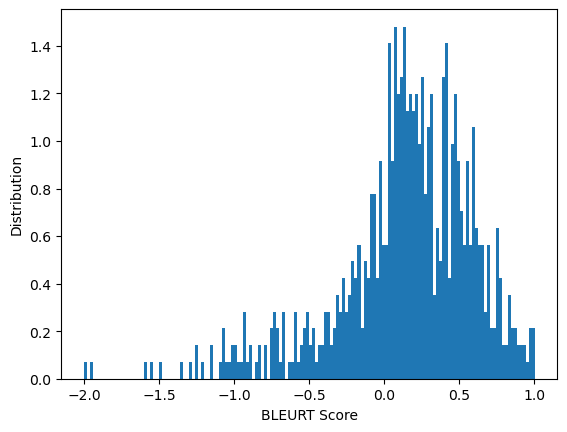

In [419]:
plt.hist(list(i2score_bleurt.values()), density=True, bins=150)  # density=False would make counts
plt.ylabel('Distribution')
plt.xlabel('BLEURT Score');

In [420]:
for i, s in top_k_bleurt:
    print(aligned_par_list[i])

['He spoke and looked at her laughing eyes, now frightening to him in their impenetrability, and as he spoke he felt all the uselessness and idleness of his words.', 'He talked and looked at her laughing eyes, which frightened him now with their impenetrable look, and, as he talked, he felt all the uselessness and idleness of his words.']
["'I'm sorry I told you,' said Sergei Ivanovich, shaking his head at his brother's agitation. 'I sent to find out where he's living, and returned him his promissory note to Trubin, which I paid. Here's how he answered me.'", '"I am sorry I told you," said Sergey Ivanovitch, shaking his head at his younger brother\'s excitement. "I sent to find out where he is living, and sent him his I.O.U. to Trubin, which I paid. This is the answer he sent me."']
['Mme Karenina got into the carriage, and Stepan Arkadyich saw with surprise that her lips were trembling and she could hardly keep back her tears.', 'Madame Karenina seated herself in the carriage, and Ste

In [421]:
scores, pars = [], []
p1, p2, p3, p4 = [], [], [], []
for i, s in top_k_bleurt:
    par_set = aligned_par_list[i]
    if len(par_set) == 2:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append('')
        p4.append('')
    elif len(par_set) == 3:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append(par_set[2])
        p4.append('')
    elif len(par_set) == 4:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append(par_set[2])
        p4.append(par_set[3])

    pars.append(aligned_par_list[i])
    scores.append(s)
    
df = pd.DataFrame(list(zip(scores, p1, p2, p3, p4)), columns=['BLEURT score', 'translation 1', 'translation 2', 'translation 3', 'translation 4'])
pd.set_option('display.max_colwidth', 0)
df.head(top_k)

,BLEURT score,translation 1,translation 2,translation 3,translation 4
0,0.636152,"He spoke and looked at her laughing eyes, now frightening to him in their impenetrability, and as he spoke he felt all the uselessness and idleness of his words.","He talked and looked at her laughing eyes, which frightened him now with their impenetrable look, and, as he talked, he felt all the uselessness and idleness of his words.",,
1,0.635414,"'I'm sorry I told you,' said Sergei Ivanovich, shaking his head at his brother's agitation. 'I sent to find out where he's living, and returned him his promissory note to Trubin, which I paid. Here's how he answered me.'","""I am sorry I told you,"" said Sergey Ivanovitch, shaking his head at his younger brother's excitement. ""I sent to find out where he is living, and sent him his I.O.U. to Trubin, which I paid. This is the answer he sent me.""",,
2,0.634280,"Mme Karenina got into the carriage, and Stepan Arkadyich saw with surprise that her lips were trembling and she could hardly keep back her tears.","Madame Karenina seated herself in the carriage, and Stepan Arkadyevitch saw with surprise that her lips were quivering, and she was with difficulty restraining her tears.",,
3,0.631609,"'Don't I see it, dear? I ought to know my gentry by now. I grew up among gentry from early on. Never mind, dear. As long as you've got your health and a clear conscience.'","""Do you suppose I don't see it, sir? It's high time I should know the gentry. Why, I've grown up from a little thing with them. It's nothing, sir, so long as there's health and a clear conscience.""",,
4,0.630958,"'I've long been meaning to tell you, maman: do you know that Levin was going to propose to Kitty when he was here the last time? He told Stiva so.'","""I'd been meaning to tell you something for a long while, mamma: did you know that Levin meant to make Kitty an offer when he was here the last time? He told Stiva so.""",,
5,0.628615,"'Why is that?' Stepan Arkadyich asked with a good-natured smile, knowing that Levin would now find everything bad.","""How do you mean for nothing?"" said Stepan Arkadyevitch with a good-humored smile, knowing that nothing would be right in Levin's eyes now.",,
6,0.623550,"'Because,' Levin interrupted again, 'with electricity, each time you rub resin against wool, a certain phenomenon manifests itself, while here it's not each time, and therefore it's not a natural phenomenon,'","""Why, because with electricity,"" Levin interrupted again, ""every time you rub tar against wool, a recognized phenomenon is manifested, but in this case it does not happen every time, and so it follows it is not a natural phenomenon.""",,
7,0.622594,"He was about to get up, but the princess, noticing that he was silent, addressed him: 'Have you come to Moscow for long? Though it seems you're involved with the zemstvo and cannot be long away.'","""Shall you be long in Moscow? You're busy with the district council, though, aren't you, and can't be away for long?""",,
8,0.619814,"Stepan Arkadyich sat down at the table and began joking with Agafya Mikhailovna, assuring her that he had not eaten such a dinner or supper for a long time.","Stepan Arkadyevitch sat down at the table and began joking with Agafea Mihalovna, assuring her that it was long since he had tasted such a dinner and such a supper.",,
9,0.616056,"And the famous doctor presented his plan of treatment by Soden waters, the main aim in the prescription of which evidently being that they could do no harm.","And the celebrated doctor expounded his plan of treatment with Soden waters, a remedy obviously prescribed primarily on the ground that they could do no harm.",,


### Evaluating BERTScore Alignments

In [422]:
sample_aligned_par_list = sample(aligned_par_list, 2000)

In [ ]:
%%capture

max_paragraph_len = 300
drop_top = 0.1

i2score_bertscore, top_k_bertscore = get_best_alignments(sample_aligned_par_list, top_k, drop_top, 'bert_score', min_paragraph_len, max_paragraph_len)
top_k_bertscore

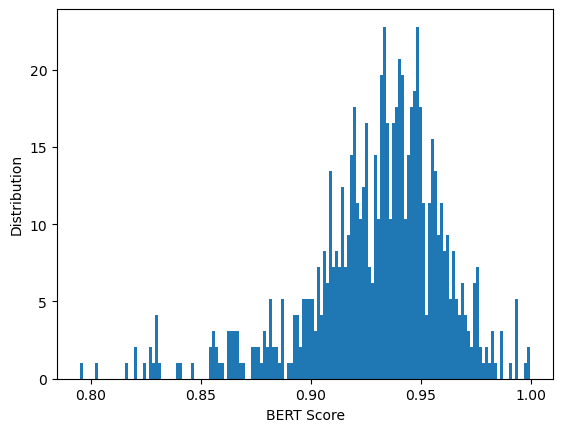

In [424]:
plt.hist(list(i2score_bertscore.values()), density=True, bins=150)  # density=False would make counts
plt.ylabel('Distribution')
plt.xlabel('BERT Score');

In [425]:
for i, s in top_k_bertscore:
    print(aligned_par_list[i])

['\'No, but how we finished!\' Petritsky went on. \'Volkov got up on the roof and said he was feeling sad. I said: "Give us music, a funeral march!" He fell asleep on the roof to the funeral march.\'', '"Oh, didn\'t we make a pretty finish!" said Petritsky. "Volkov climbed onto the roof and began telling us how sad he was. I said: \'Let\'s have music, the funeral march!\' He fairly dropped asleep on the roof over the funeral march."']
["'Well, yes, I picture things in the most coarse, vile way, she went on. 'It's my illness. Maybe it will pass ...'", '"Oh, well, everything presents itself to me, in the coarsest, most loathsome light," she went on. "That\'s my illness. Perhaps it will pass off."']
["'Ah, if you'd seen it, Countess,' said Stepan Arkadyich. ' And his wife is here ... It was terrible to see her ... She threw herself on the body. They say he was the sole provider for a huge family.22 It's terrible!'", '"Oh, if you had seen it, countess," said Stepan Arkadyevitch. "And his w

In [426]:
scores, pars = [], []
p1, p2, p3, p4 = [], [], [], []
for i, s in top_k_bertscore:
    par_set = aligned_par_list[i]
    if len(par_set) == 2:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append('')
        p4.append('')
    elif len(par_set) == 3:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append(par_set[2])
        p4.append('')
    elif len(par_set) == 4:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append(par_set[2])
        p4.append(par_set[3])

    pars.append(aligned_par_list[i])
    scores.append(s)
    
df = pd.DataFrame(list(zip(scores, p1, p2, p3, p4)), columns=['BERT score', 'translation 1', 'translation 2', 'translation 3', 'translation 4'])
pd.set_option('display.max_colwidth', 0)
df.head(top_k)

,BERT score,translation 1,translation 2,translation 3,translation 4
0,0.963299,"'No, but how we finished!' Petritsky went on. 'Volkov got up on the roof and said he was feeling sad. I said: ""Give us music, a funeral march!"" He fell asleep on the roof to the funeral march.'","""Oh, didn't we make a pretty finish!"" said Petritsky. ""Volkov climbed onto the roof and began telling us how sad he was. I said: 'Let's have music, the funeral march!' He fairly dropped asleep on the roof over the funeral march.""",,
1,0.963236,"'Well, yes, I picture things in the most coarse, vile way, she went on. 'It's my illness. Maybe it will pass ...'","""Oh, well, everything presents itself to me, in the coarsest, most loathsome light,"" she went on. ""That's my illness. Perhaps it will pass off.""",,
2,0.962769,"'Ah, if you'd seen it, Countess,' said Stepan Arkadyich. ' And his wife is here ... It was terrible to see her ... She threw herself on the body. They say he was the sole provider for a huge family.22 It's terrible!'","""Oh, if you had seen it, countess,"" said Stepan Arkadyevitch. ""And his wife was there. … It was awful to see her!… She flung herself on the body. They say he was the only support of an immense family. How awful!""",,
3,0.962380,"He spoke courteously, respectfully, but so firmly and stubbornly that for a long time she was unable to make any reply.","He had spoken courteously, deferentially, yet so firmly, so stubbornly, that for a long while she could make no answer.",,
4,0.962126,"'Bold steeds I can tell by their something-or-other thighs, and young men in love by the look in their eyes,12 declaimed Stepan Arkadyich. 'You've got everything before you.'","""'I know a gallant steed by tokens sure, And by his eyes I know a youth in love,'"" declaimed Stepan Arkadyevitch. ""Everything is before you.""",,
5,0.962103,"'But how, Alexei, teach me how?' she said with sad mockery at the hopelessness of her situation. 'Is there a way out of such a situation? Am I not my husband's wife?'","""But how, Alexey, tell me how?"" she said in melancholy mockery at the hopelessness of her own position. ""Is there any way out of such a position? Am I not the wife of my husband?""",,
6,0.962100,"'Good-bye, my friend,' the countess replied. 'Let me kiss your pretty little face. I'll tell you simply, directly, like an old woman, that I've come to love you.'","""Goodbye, my love,"" answered the countess. ""Let me have a kiss of your pretty face. I speak plainly, at my age, and I tell you simply that I've lost my heart to you.""",,
7,0.961900,"'Wait, wait,' said Stepan Arkadyich, smiling and touching his hand. 'I've told you what I know, and I repeat that in this subtle and delicate matter, as far as I can surmise, the chances seem to be on your side.'","""You wait a bit, wait a bit,"" said Stepan Arkadyevitch, smiling and touching his hand. ""I've told you what I know, and I repeat that in this delicate and tender matter, as far as one can conjecture, I believe the chances are in your favor.""",,
8,0.961727,"'No, really, I forget. Or did I dream it? Hold on, hold on! What's the use of getting angry? If you'd drunk four bottles each, like I did last night, you'd forget where you flopped down. Hold on, I'll remember in a second!'","""No, I've forgotten really. Or was it a dream? Wait a bit, wait a bit! But what's the use of getting in a rage. If you'd drunk four bottles yesterday as I did you'd forget where you were lying. Wait a bit, I'll remember!""",,
9,0.961647,"'Kostya, tell them that if the merchant Ryabinin comes — I told him to come today - they should receive him and have him wait...'","""Kostya, give orders that if the merchant Ryabinin comes… I told him to come today, he's to be brought in and to wait for me.…""",,


### Looking at longer alignments

In [431]:
min_paragraph_len = 300
max_paragraph_len = 600
top_k = 30
drop_top = 0.1

In [432]:
i2score_long, top_k_long = get_best_alignments(aligned_par_list, top_k, drop_top, 'sim', min_paragraph_len, max_paragraph_len)
top_k_long

[(5471, 0.9158363342285156),
 (768, 0.9157002568244934),
 (4374, 0.915612518787384),
 (7576, 0.9155560731887817),
 (2475, 0.9155310392379761),
 (2453, 0.9154614210128784),
 (17903, 0.9154428243637085),
 (15757, 0.9154320955276489),
 (27340, 0.9154157837231954),
 (7421, 0.9153907895088196),
 (22274, 0.9153443276882172),
 (13978, 0.9153256416320801),
 (217, 0.9153237342834473),
 (24211, 0.915296753247579),
 (31389, 0.9152750968933105),
 (6691, 0.9152682423591614),
 (1770, 0.9152035117149353),
 (1489, 0.9150765538215637),
 (25513, 0.9150715470314026),
 (1352, 0.9150093793869019),
 (3848, 0.9149894118309021),
 (9037, 0.9149821698665619),
 (5669, 0.9149142503738403),
 (29665, 0.9148956934611002),
 (13894, 0.9148746728897095),
 (10455, 0.9148549934228262),
 (5160, 0.9147903919219971),
 (24405, 0.9147666394710541),
 (60, 0.9147247076034546),
 (4482, 0.914709210395813)]

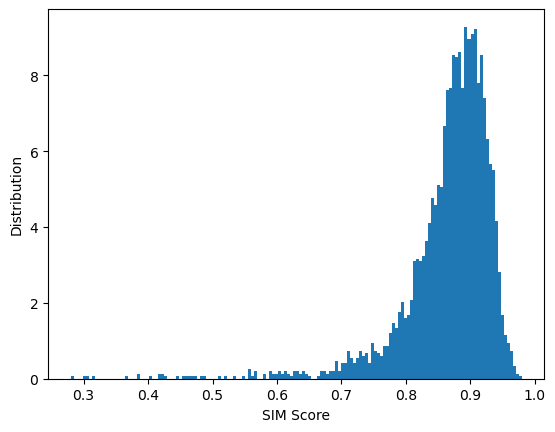

In [433]:
plt.hist(list(i2score_long.values()), density=True, bins=150)  # density=False would make counts
plt.ylabel('Distribution')
plt.xlabel('SIM Score');

In [437]:
scores, pars = [], []
p1, p2, p3, p4 = [], [], [], []
for i, s in top_k_long:
    par_set = aligned_par_list[i]
    if len(par_set) == 2:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append('')
        p4.append('')
    elif len(par_set) == 3:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append(par_set[2])
        p4.append('')
    elif len(par_set) == 4:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append(par_set[2])
        p4.append(par_set[3])

    pars.append(aligned_par_list[i])
    scores.append(s)
    
df = pd.DataFrame(list(zip(scores, p1, p2, p3, p4)), columns=['BERT score', 'translation 1', 'translation 2', 'translation 3', 'translation 4'])
pd.set_option('display.max_colwidth', 0)
df.head(top_k)

,BERT score,translation 1,translation 2,translation 3,translation 4
0,0.881216,"""What shall I do now, Dmitry Prokofich?"" asked Pulkheriya Aleksandrovna, almost in tears. ""How can I tell Rodya not to come? Yesterday he so insistently demanded that Petr Petrovich be refused, and now we're told that Rodya can't be received! He'll come on purpose, as soon as he finds out, and... then what will happen?""","""What am I to do now, Dmitri Prokofitch?"" began Pulcheria Alexandrovna, almost weeping. ""How can I ask Rodya not to come? Yesterday he insisted so earnestly on our refusing Pyotr Petrovitch and now we are ordered not to receive Rodya! He will come on purpose if he knows, and… what will happen then?""","'What am I to do now, Dmitry Prokofich?' said Pulkheria Aleksandrovna, almost in tears. 'I mean, how can I tell Rodya not to come? He was so adamant yesterday about demanding that we say no to Pyotr Petrovich, and now we're being told not to let Rodya in, either! AndI mean, he'll be sure to come when he finds out, and... what will happen then?'","""what am I to do now, Dmitri Prokofich?"" Pulcheria Alexandrovna began to say, almost in tears. ""How am I to suggest that Rodya not come? Yesterday he demanded so insistently that we refuse Pyotr Petrovich, and now we're told not to receive him! But if he finds out, he will come on purpose...and what will happen then?"""
1,0.881145,"'Where could you possibly have heard that? But what can one expect of you Karamazovs — posing as some sort of grand and ancient noblemen, when your father used to go trotting round other people's tables playing the buffoon and only got his seat in the kitchen out of charity. All right, I'm just the son of a priest, anda greenhorn compared to the likes of you, but don't think you can get away with those smiling insults. I too have my honour, Aleksey Fyodorovich. It's out of the question that I could be any relation of Grushenka, a public prostitute, and I'll have you understand that, sir!'","""Where did you hear that? No, you Karamazovs pose at being descended from some great and ancient noble family, while your father goes running around like a buffoon to other people's tables, even though he's admitted to the kitchen only out of charity. Let's agree, I'm just the son of a priest and I'm nothing compared to you noblemen, but don't insult me so gleefully and recklessly. I have my honor, too, Aleksey Fyodorovich. I can't be related to Grushenka, a common. whore. I ask you to understand, sir!""","""Where can you have heard it? You Karamazovs brag of being an ancient, noble family, though your father used to run about playing the buffoon at other men's tables, and was only admitted to the kitchen as a favor. I may be only a priest's son, and dirt in the eyes of noblemen like you, but don't insult me so lightly and wantonly. I have a sense of honor, too, Alexey Fyodorovitch, I couldn't be a relation of Grushenka, a common harlot. I beg you to understand that!""","""Where could you have heard that? No, you gentleman Karamazovs pose as some sort of great and ancient nobility, when your father played the fool at other men's tables and got fed in the kitchen out of charity. Granted I'm only a priest's son and a worm next to you noblemen, but still don't go offending me so gaily and easily. I, too, have my honor, Alexei Fyodorovich. I could not be the relative of Grushenka, a loose woman, kindly understand that, sir!"""
2,0.881128,"""But you're right, Sonya,"" he said softly at last. He had in that moment been transformed; his artificially arrogant and weakly challenging tone had disappeared. Even his voice suddenly slackened. ""Yesterday I told you that I'd come not to ask forgiveness, yet I almost began by asking for it.... What I said about Luzhin and about God was for myself. . ..1 asked forgiveness, Sonya...""","""Of course you're right, Sonia,"" he said softly at last. He was suddenly changed. His tone of assumed arrogance and helpless defiance was gone. Ev

### Looking at worse alignments

In [446]:
min_paragraph_len = 300
max_paragraph_len = 600
top_k = 30
drop_top = 0.90

In [447]:
i2score_bad, top_k_bad = get_best_alignments(aligned_par_list, top_k, drop_top, 'sim', min_paragraph_len, max_paragraph_len)
top_k_bad

[(24459, 0.7905352314313253),
 (20294, 0.7901443839073181),
 (20311, 0.7900887727737427),
 (8061, 0.78993292649587),
 (15873, 0.7898623943328857),
 (20731, 0.7897358536720276),
 (20826, 0.789438009262085),
 (26680, 0.78940216700236),
 (31233, 0.789392352104187),
 (5623, 0.7893076539039612),
 (20174, 0.7890119552612305),
 (12890, 0.7887555360794067),
 (8012, 0.7885983188947042),
 (20092, 0.7885397672653198),
 (20787, 0.7884634137153625),
 (29432, 0.7884443600972494),
 (10684, 0.7883194188276926),
 (28421, 0.7882408698399862),
 (19155, 0.7881723046302795),
 (13199, 0.7880795001983643),
 (6526, 0.7878482341766357),
 (11733, 0.7877967357635498),
 (11005, 0.787505159775416),
 (26575, 0.7867241700490316),
 (25993, 0.7860886454582214),
 (10589, 0.7856468856334686),
 (7155, 0.7855209708213806),
 (2393, 0.7854582071304321),
 (25081, 0.7853829463322958),
 (5665, 0.7852954864501953)]

In [448]:
scores, pars = [], []
p1, p2, p3, p4 = [], [], [], []
for i, s in top_k_bad:
    par_set = aligned_par_list[i]
    if len(par_set) == 2:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append('')
        p4.append('')
    elif len(par_set) == 3:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append(par_set[2])
        p4.append('')
    elif len(par_set) == 4:
        p1.append(par_set[0])
        p2.append(par_set[1])
        p3.append(par_set[2])
        p4.append(par_set[3])

    pars.append(aligned_par_list[i])
    scores.append(s)
    
df = pd.DataFrame(list(zip(scores, p1, p2, p3, p4)), columns=['BERT score', 'translation 1', 'translation 2', 'translation 3', 'translation 4'])
pd.set_option('display.max_colwidth', 0)
df.head(top_k)

,BERT score,translation 1,translation 2,translation 3,translation 4
0,0.790535,"'Oh yes, you're right, you're right, I can see that he will! Ah, Misha, and I was going to give you a kiss for your trouble ... If you don't get it wrong there's ten roubles for you, now dash off as quick as you can ... The main thing is the champagne, get them to roll out the champagne, and the cognac, and the white and the red wine, and all of it as it was that time ...'","""He will, I can see that, he'll get mixed up! Hey, Misha, I was about to send you off on this commission with a kiss. . . . If you don't mix it up, I'll give you ten rubles. Off you go! Champagne, that's the main thing to bring, and brandy, red wine, white wine, and everything else, as it was then. ... They know what I took last time.""","""He will, I see he will! Eh, Misha! Why, I was going to kiss you for the commission. … If you don't make a mistake, there's ten roubles for you, run along, make haste. … Champagne's the chief thing, let them bring up champagne. And brandy, too, and red and white wine, and all I had then.… They know what I had then.""","""He will, I can see, he'll get it all wrong! Eh, Misha, and I was about to give you a kiss for your services. If you keep it all straight, you'll get ten roubles, now off with you ... Champagne above all, let them break out the champagne, and some cognac, and red wine, and white wine, and all the rest, like the other time ... They'll remember how it was."""
1,0.790144,"""Do you see that aspen tree?"" remarked Bazarov. ""I mean the one growing at the edge of a depression, where a brick kiln used to stand? Well, when I was a boy I used to believe that, together, the depression and the aspen tree constituted a special talisman, in that, when near them, I never found time hang heavy upon my hands. Of course, the explanation is that in those days I failed to understand that that immunity from ennui was due to the very fact of my being a boy. But, now that I am grown up, the talisman seems to have lost its power.""","""That aspen-tree,"" began Bazarov, ""reminds me of my childhood; it grows at the edge of the clay-pits where the bricks were dug, and in those days I believed firmly that that clay-pit and aspen-tree possessed a peculiar talismanic power; I never felt dull near them. I did not understand then that I was not dull, because I was a child. Well, now I'm grown up, the talisman's lost its power.""",,
2,0.790089,"""I am thinking of the pleasant life that my parents must lead. To think that at sixty my father can still fuss about, and talk of 'palliatives,' and doctor people, and do the bountiful to the peasants, and, in short, enjoy himself, and that my mother has her days so crammed full of occupations (including sighing and groaning) that she does not know which to begin upon first!","""I'm thinking life is a happy thing for my parents. My father at sixty is fussing around, talking about 'palliative' measures, doctoring people, playing the bountiful master with the peasants—having a festive time, in fact; and my mother's happy too; her day's so chockful of duties of all sorts, and sighs and groans that she's no time even to think of herself; while I…""",,
3,0.789933,"""Let's go, let's go!"" his father says. ""They're drunk, misbehaving, those fools: let's go. Don't look!"" He tries to lead his son away, but the boy breaks from his father's arms; beside himself, he runs toward the horse. But the poor horse is on her last legs. Gasping for breath, she stops, and then tries to pull again, about to drop.","Father, they are beating the poor horse!"" ""Come along, come along!"" said his father. ""They are drunken and foolish, they are in fun; come away, don't look!"" and he tried to draw him away, but he tore himself away from his hand, and, beside himself with horror, ran to the horse. The poor beast was in a bad way. She was gasping, standing still, then tugging again and almost falling.","'Papa, what are they doing? Papa, the